# Correct follow up days and handle outliers

In this notebook, a survival analysis will be conducted on all study units (hospital admissions during the pandemic with a positive COVID test at the beginning of the stay). It will be investigated whether vaccines, as well as their quantity and other variables, influence the probability of survival. Additionally, a temporal analysis will be performed to determine when the event of interest (patient death) occurs.

## 0. Libraries and functions

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import csv

In [22]:
def plot_dichotomous_variable(variable_series, variable_name, save_path):
    # Calculate the count and percentage values
    count_values = variable_series.value_counts()
    percentage_values = variable_series.value_counts(normalize=True) * 100

    # Create the plot
    fig, ax = plt.subplots(figsize=(6,7))
    count_values.plot(kind='bar', ax=ax, color=['lightgreen', 'lightcoral'])

    # Add labels and title
    ax.set_xticklabels(count_values.index.map({0: 'Survivor', 1: 'Deceased'}), rotation=0)
    ax.set_xlabel(variable_name)
    ax.set_ylabel('Number of Occurrences')
    ax.set_title(f'Distribution of {variable_name}')

    # Add percentages above the bars
    for i, value in enumerate(count_values):
        percentage_text = f'{percentage_values[i]:.3f}%'
        text_height = max(value * 0.05, 0.1)
        ax.text(i, value + text_height, percentage_text, ha='center')

    # Remove top and right borders
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Adjust ylim to ensure all text is within the plot boundaries
    ax.set_ylim(0, max(count_values) + max(count_values) * 0.2)

    # Save figure
    fig.savefig(save_path+".tiff", bbox_inches='tight')
    fig.savefig(save_path+".png", bbox_inches='tight')

    # Show the plot
    plt.show()

In [23]:
def plot_numeric_variable_stratified(numeric_values, dichotomous_values, numeric_name, dichotomous_name, save_path):
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(10, 6))

    # Rename 0 and 1 in dichotomous_values
    dichotomous_values = np.where(dichotomous_values == 0, 'Survivor', 'Deceased')

    # Set bins for the histogram
    bins = 30

    # Define colors for each dichotomous value
    colors = {'Survivor': 'lightgreen', 'Deceased': 'lightcoral'}

    # Stratify the data by dichotomous_values
    dichotomous_groups = {outcome: numeric_values[dichotomous_values == outcome] for outcome in set(dichotomous_values)}

    # Plot histogram for each dichotomous_values with specified colors
    for outcome, values in dichotomous_groups.items():
        ax.hist(values, bins=bins, alpha=0.7, label=f'{dichotomous_name} = {outcome}', color=colors[outcome])

    # Remove top and right borders
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Add labels and title
    ax.set_xlabel(numeric_name)
    ax.set_ylabel('Number of Occurrences')
    ax.set_title(f'Histogram of {numeric_name} Stratified by {dichotomous_name}')

    # Add legend
    ax.legend()

    # Save figure
    fig.savefig(save_path+".tiff", bbox_inches='tight')
    fig.savefig(save_path+".png", bbox_inches='tight')

    # Show the plot
    plt.show()


## 1. Load data

The pickle file is read, which contains all the variables. Binary variables are encoded as 0/1, and null values can be present in the variables related to death, indicating that the event (death) does not occur in that instance (nor 30 days after discharge). Thus, it is defined that the patient does not die from Covid.

In [24]:
df = pd.read_pickle("data/patient_imputed.pkl")

In [25]:
df.drop(columns="id").head()

,sex,age,num_shots,type_center,vaccinated,icu,inpatient_days,admission_datetime,discharge_datetime,hospital_outcome,...,lab_lymphocyte_percentage,lab_mch,lab_mcv,lab_neutrophil,lab_neutrophil_percentage,lab_platelet,lab_potassium,lab_rbc,lab_sodium,lab_urea
0,0,26,0,County Hospital,0,1,15,2021-07-29,2021-08-13,0,...,22.7,29.80,84.90,3.29,69.20,143.00,4.50,4.98,136.00,32.00
1,0,50,2,County Hospital,1,0,6,2022-01-01,2022-01-07,0,...,16.4,29.61,89.41,6.22,75.45,219.31,4.18,4.59,136.98,50.64
2,0,22,0,County Hospital,0,0,6,2021-02-03,2021-02-09,0,...,10.1,28.10,76.20,9.04,83.40,248.00,3.80,5.79,133.00,33.00
3,1,41,0,County Hospital,0,0,10,2021-05-29,2021-06-08,0,...,3.5,28.80,86.80,11.96,93.60,220.00,3.90,5.11,134.00,20.00
4,0,43,0,County Hospital,0,0,11,2021-05-29,2021-06-09,0,...,5.8,30.20,89.50,9.11,91.10,229.00,3.90,5.00,131.00,36.64


Some patients may have a date of death (`death_datetime`) without it being a missing value but with a `hospital_outcome` equal to 0. This is because the patient dies more than 30 days after hospital discharge, so it is considered that they did not die from COVID. For the study we want to conduct, these deaths are not of interest, so we will encode those dates as missing values.

In [26]:
filtered_df = df[(df["hospital_outcome"] == 0) & (~df["death_datetime"].isna())]
print(filtered_df[["hospital_outcome", "death_datetime", "delta_days_death"]])

      hospital_outcome death_datetime  delta_days_death
34                   0     2022-07-29               184
143                  0     2022-11-21               102
164                  0     2022-01-13               346
169                  0     2022-12-31                97
175                  0     2021-11-25               100
...                ...            ...               ...
49922                0     2021-03-17                58
49935                0     2022-07-06               109
49936                0     2021-07-28               184
49938                0     2022-03-14                54
49939                0     2022-05-05               305

[2504 rows x 3 columns]


Let's remove the columns `death_datetime` and `delta_days_death` because they do not belong to deaths caused by COVID and check it.

In [27]:
nan_count = df[["death_datetime", "delta_days_death"]].isna().sum()
print("Number of NaN values  before processing  in 'death_datetime':", nan_count["death_datetime"])
print("Number of NaN values  before processing  in 'delta_days_death':", nan_count["delta_days_death"])

df.loc[(df["hospital_outcome"] == 0) & (~df["death_datetime"].isna()), "death_datetime"] = pd.NaT
df.loc[(df["hospital_outcome"] == 0) & (~df["delta_days_death"].isna()), "delta_days_death"] = pd.NA

nan_count = df[["death_datetime", "delta_days_death"]].isna().sum()
print("\nNumber of NaN values after processing  in 'death_datetime':", nan_count["death_datetime"])
print("Number of NaN values after processing  in 'delta_days_death':", nan_count["delta_days_death"])

Number of NaN values  before processing  in 'death_datetime': 27748
Number of NaN values  before processing  in 'delta_days_death': 27748

Number of NaN values after processing  in 'death_datetime': 30252
Number of NaN values after processing  in 'delta_days_death': 30252


## 2. Handle Outliers


### 2.1 Prepare the data

The data is transformed to align with the needs of the survival function.

In [28]:
# Indicates if the event occurs or nor
print(df["hospital_outcome"])

# Is the follow-up time
print(df["delta_days_death"])

0        0
1        0
2        0
3        0
4        0
        ..
49960    0
49961    0
49965    0
49966    0
49968    0
Name: hospital_outcome, Length: 37472, dtype: category
Categories (2, int64): [0, 1]
0        <NA>
1        <NA>
2        <NA>
3        <NA>
4        <NA>
         ... 
49960    <NA>
49961    <NA>
49965    <NA>
49966    <NA>
49968    <NA>
Name: delta_days_death, Length: 37472, dtype: Int64


We can see that `hospital_outcome` takes two values, *1: the event occurs* (the patient dies from COVID) or *0: the event does not occur*. So, all records where hospital outcome is equal to 0 will represent subjects who withdrew alive, leading to what is known as censored data. The follow-up time is represented by the variable `delta_date_death`, which indicates the time difference between the patient's inclusion in the analysis and the date of death (in days). If the record represents NA, it implies that the patient did not experience the event of interest (and therefore `hospital_outcome` = 0 in that row).

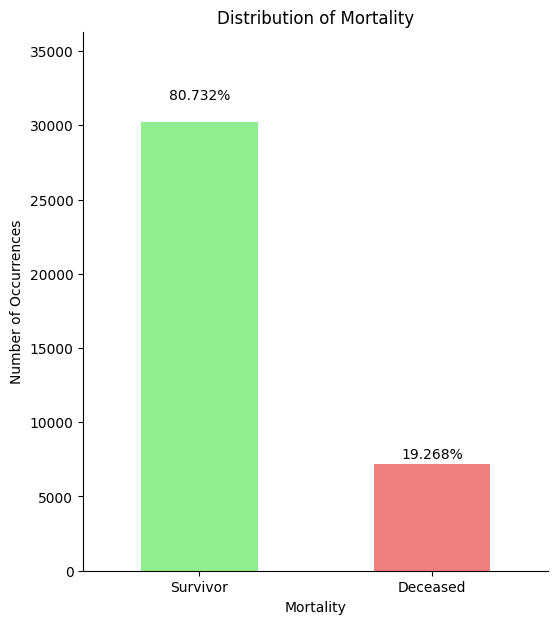

In [29]:
plot_dichotomous_variable(df["hospital_outcome"], "Mortality", "../OUTPUT_figures_tables/Figure_1")

In survival analysis, we understand that individuals who do not experience the event have missing values in the delta_days_death variable. However, for conducting survival analysis, it is essential to have the follow-up time values for both the records with the event and those without.

For the records without the event (survivors), we know the dates of hospital admission (`admission_datetime`) and discharge(`discharge_datetime`. Additionally, we are aware that they do not experience the event for at least 30 days post-discharge. Therefore, their follow-up time can be calculated as:

$$
\text{days}(\text{discharge date} - \text{admission date}) + 30
$$

In [30]:
df[df["hospital_outcome"] == 0]["delta_days_death"].isna().value_counts()

delta_days_death
True    30252
Name: count, dtype: int64

In [31]:
# Llena los valores NA en delta_days
df['delta_days_death'].fillna((df['discharge_datetime'] - df['admission_datetime']).dt.days + 30, inplace=True)

# Let's rename the var to be more accure with the new significate
df.rename(columns={'delta_days_death': 'followup_days'}, inplace=True)

# Set a non null datatype
df['followup_days'] = df['followup_days'].astype(int)

/tmp/ipykernel_36854/2951436429.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['delta_days_death'].fillna((df['discharge_datetime'] - df['admission_datetime']).dt.days + 30, inplace=True)


In [32]:
print("Follow up days stats:\n")
print(df["followup_days"].describe())

Follow up days stats:

count    37472.000000
mean        35.577284
std         16.335861
min          0.000000
25%         33.000000
50%         36.000000
75%         41.000000
max        404.000000
Name: followup_days, dtype: float64


The `followup_days` variable in survival analysis denotes the duration each subject is observed until a specific event (disease) or 30 days before the discharge datetime, at which point they are removed from the observation. Let's plot the `followup_days` histogram, stratified by `hospital_outcome`.

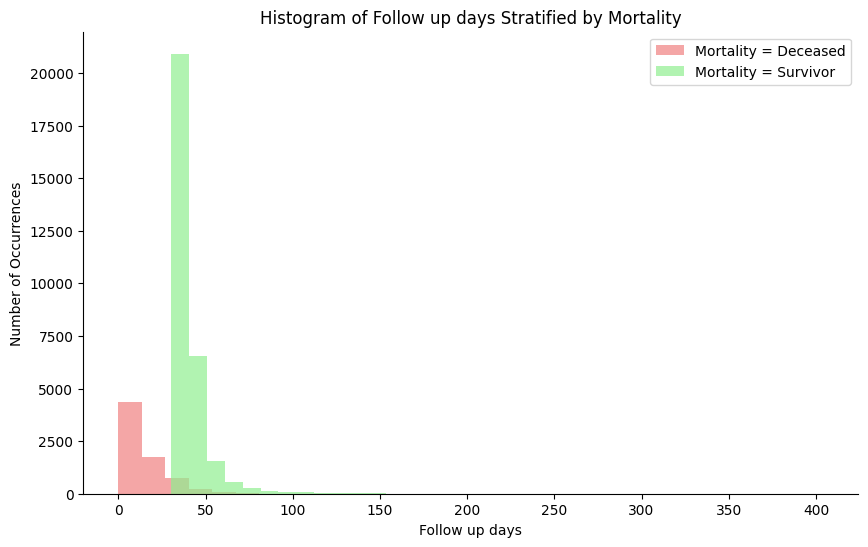

In [33]:
plot_numeric_variable_stratified(df["followup_days"],
                                 df["hospital_outcome"],
                                 "Follow up days", 
                                 "Mortality",
                                 "../OUTPUT_figures_tables/Figure_2")

From the histogram, we can interpret that people who survive have a longer follow-up than those who do not. It also detects possible `outliers`; let's investigate them. A control variable to perform or not this analysis is configured.

https://academic.oup.com/psychsocgerontology/article/75/5/e13/5368175

In [34]:
CHECK_OUTLIERS = True
trimmer = 0.5 # (drop 0.5% upper)

/home/juanluisgonzalez/FPS_proyects/Vacc_analisys/venv/lib64/python3.9/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/home/juanluisgonzalez/FPS_proyects/Vacc_analisys/venv/lib64/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/juanluisgonzalez/FPS_proyects/Vacc_analisys/venv/lib64/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', Tru

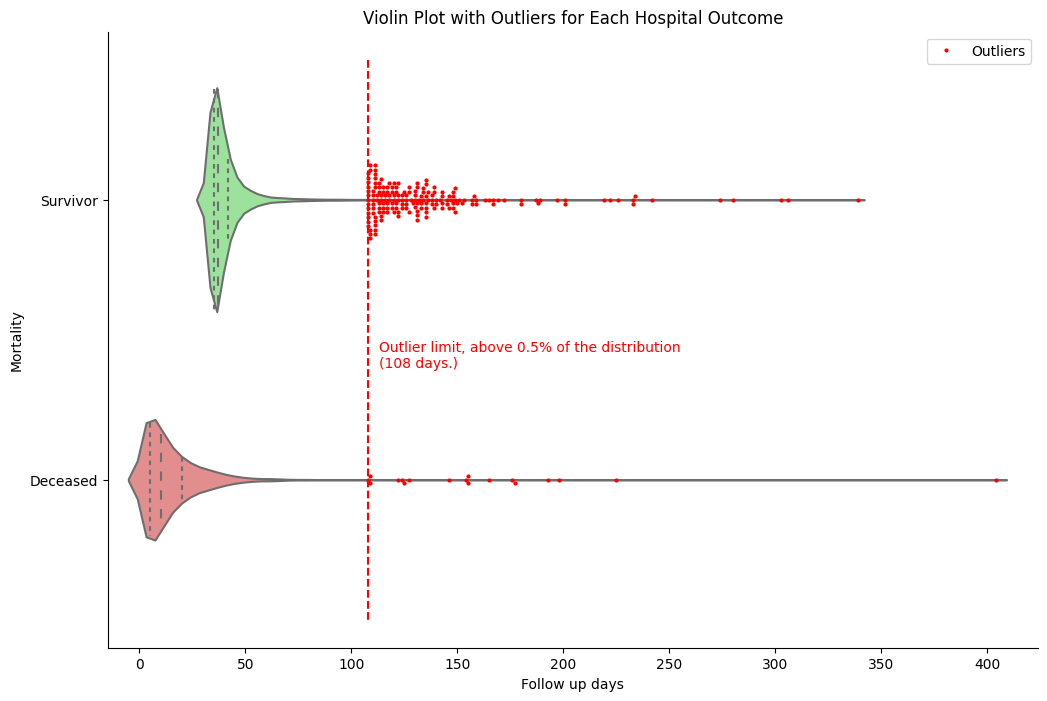

In [35]:
if CHECK_OUTLIERS:
    # Identify outliers for each unique outcome
    outliers = pd.DataFrame()
    
    # Rename to be more clear
    outcome_labels = {0: 'Survivor', 1: 'Deceased'}
    df['hospital_outcome'] = df['hospital_outcome'].map(outcome_labels)

    percent_drop = trimmer/100
    quantile_keep = 1 - percent_drop

    outliers = df[df['followup_days'] >= df['followup_days'].quantile(quantile_keep)]
    upper_limit = int(df['followup_days'].quantile(quantile_keep))

# PLOT
    
    # Map hospital outcome labels to new names
    color_palette = {'Survivor': 'lightgreen', 'Deceased': 'lightcoral'}
    
    fig, ax = plt.subplots(figsize=(12, 8))
    sns.violinplot(y='hospital_outcome', x='followup_days', data=df,
                  palette=color_palette, inner="quartile", ax=ax)

    # Create a single swarmplot outside the loop
    sns.swarmplot(y='hospital_outcome', x='followup_days', data=outliers,
                 color='red', marker='o', size=3, ax=ax)

    # Create a legend with a red dot and text
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red',
                                  markersize=4, label='Outliers')]

    # Vline to draw upper limit
    ax.vlines(x=upper_limit, ymax=1.5, ymin=-0.5, color="red", linestyles='dashed')
    ax.text(x=upper_limit+5, y=0.6, s=f"Outlier limit, above {trimmer}% of the distribution\n({upper_limit} days.)", color="red")

    # Remove top and right borders
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Add legend
    ax.legend(handles=legend_elements, loc='upper right')

    ax.set_title('Violin Plot with Outliers for Each Hospital Outcome')
    ax.set_xlabel("Follow up days")
    ax.set_ylabel("Mortality")

    #Save figure
    fig.savefig("../OUTPUT_figures_tables/Figure_3.png", bbox_inches='tight')
    fig.savefig("../OUTPUT_figures_tables/Figure_3.tiff", bbox_inches='tight')

    plt.show()

Outliers are defined as the `followup_days` values that fall above the 99.5th percentile of the data. We should remove these outliers.

In [36]:
if CHECK_OUTLIERS:    
    # Get the number of rows before removal
    rows_before_removal = len(df)
    
    # Remove the rows based on the index
    df = df.drop(index=outliers.index)
    
    # Get the number of rows after removal
    rows_after_removal = len(df)
    
    # Print the counts
    print(f"Rows before removal: {rows_before_removal}")
    print(f"Rows after removal: {rows_after_removal}")
    
    # Calculate and print the number of rows removed
    rows_removed = outliers.shape[0]
    print(f"Outliers removed: {rows_removed}")

Rows before removal: 37472
Rows after removal: 37274
Outliers removed: 198


/home/juanluisgonzalez/FPS_proyects/Vacc_analisys/venv/lib64/python3.9/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


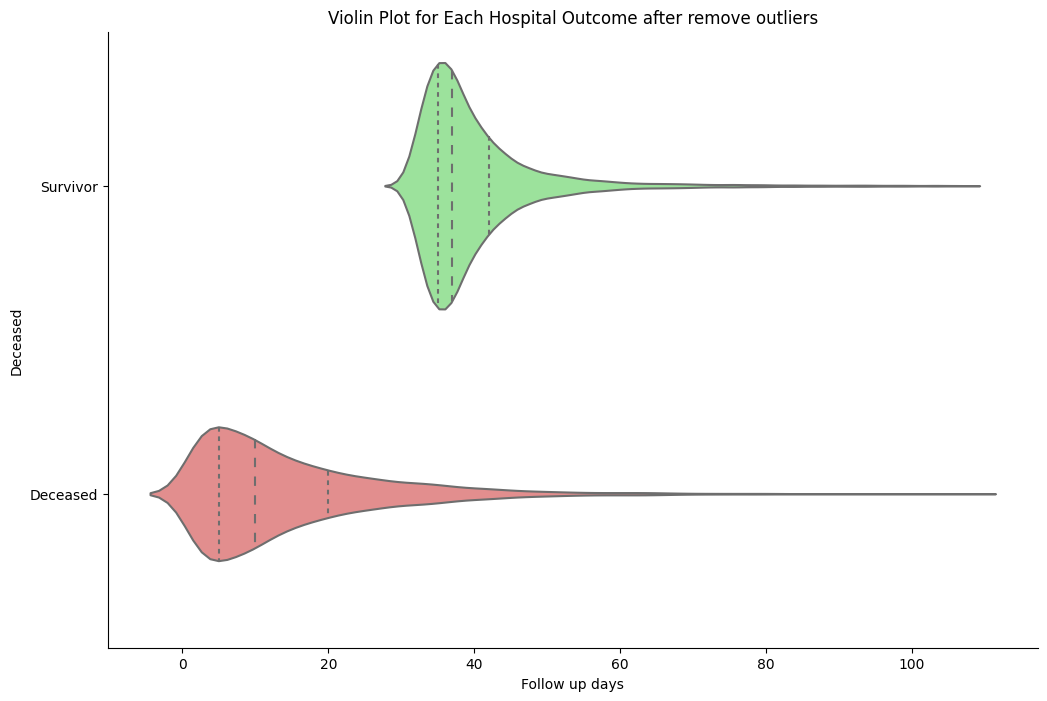

In [37]:
if CHECK_OUTLIERS:    
  
    # Create violin plot with outliers and legend
    fig, ax = plt.subplots(figsize=(12, 8))
    sns.violinplot(y='hospital_outcome', x='followup_days', data=df,palette=color_palette, inner="quartile", ax=ax)
    ax.set_title('Violin Plot for Each Hospital Outcome after remove outliers')
    ax. set_xlabel("Follow up days")
    ax.set_ylabel("Deceased")

    # Remove top and right borders
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    #Save figure
    fig.savefig("../OUTPUT_figures_tables/Figure_4.png", bbox_inches='tight')
    fig.savefig("../OUTPUT_figures_tables/Figure_4.tiff", bbox_inches='tight')

    plt.show()

Now that we have the follow-up time variable for all cases, we can proceed to change the data in a way that the presentation format is required by the `scikit-survival` library. To do this, an array of tuples will be passed. Each tuple will contain 2 elements. The first indicates whether the value is censored or not (we will go into detail later), and the second will be the value of the follow-up variable.

### 2.2 Save the data

Let's save the df and perform the surivival analysis on R.

In [38]:
df["hospital_outcome"] = df["hospital_outcome"].map({"Survivor":0, "Deceased":1})

In [39]:
file_path = "../2_survival_analysis/data/survival_data.csv"
df.to_csv(file_path, index=False, quotechar='"', quoting=csv.QUOTE_NONNUMERIC)

# Save the patient without ouliers
df.to_pickle("data/patient_imputed_cleaned.pkl")

Let's drop from geocount_df the outliers.

In [ ]:
df_geocuount = pd.read_pickle("data/geocount_df.pkl")
overlapping_index = df.index.intersection(df_geocuount.index)
df_geocuount_clean = df_geocuount.loc[overlapping_index]

# Save the patient geo info without ouliers
df_geocuount_clean.to_pickle("data/geocount_df_cleaned.pkl")